In [8]:
!echo $CONDA_DEFAULT_ENV

exp-tracking


In [9]:
!python -V

Python 3.9.12


In [10]:
import pandas as pd

In [11]:
import pickle

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
from sklearn.feature_extraction import DictVectorizer

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///../mlflow.db")
mlflow.set_experiment("nyc_taxi_exp")

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2022/05/30 01:39:34 INFO mlflow.tracking.fluent: Experiment with name 'nyc_taxi_exp' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc_taxi_exp', tags={}>

In [15]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'].copy())
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'].copy())
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str) 

In [16]:
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'].copy())
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'].copy())

In [17]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

In [18]:
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

In [19]:
#df = df[df['trip_type'] == 2]

In [20]:
df['duration'].describe(percentiles=[.95, .98, .99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [21]:
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

/home/sebastian/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

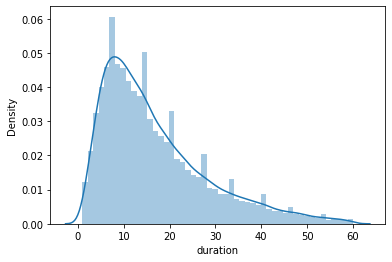

In [22]:
sns.distplot(df['duration'])

In [23]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [24]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [25]:
# One hot encoding
df[categorical] = df[categorical].astype(str) #Dictionary vectorizer takes as input non-integers

In [26]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [27]:
dv = DictVectorizer()

In [28]:
X_train = dv.fit_transform(train_dicts)

In [29]:
dv.feature_names_[:10]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11']

In [30]:
target = 'duration'
y_train = df[target].values

In [31]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [32]:
#Baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

/home/sebastian/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/sebastian/anaconda3/envs/exp-tracking/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


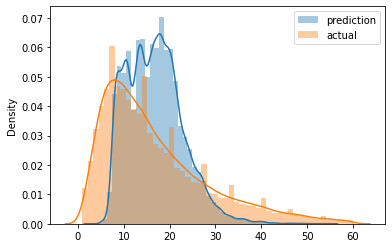

In [33]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()
plt.show()

In [34]:
mean_squared_error(y_train, y_pred, squared=False)

9.838799799886667

## Validation with February data

In [35]:
#Validate with February data
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'].copy())
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'].copy())
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str) 
    
    return df

In [36]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [37]:
len(df_train), len(df_val)

(73908, 61921)

In [38]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [39]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [41]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## Using MLflow to keep track of model iterations

In [43]:
with mlflow.start_run():
    mlflow.set_tag("Dev", "Sebastian")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    
    mlflow.log_param("alpha", alpha)
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)